In [14]:
import os
import datetime

import numpy as np
import pandas as pd
import scipy

import statsmodels as sm
import statsmodels.formula.api as smf
from patsy.contrasts import ContrastMatrix
import patsy

import matplotlib.pyplot as plt
import matplotlib.pylab as mpl
import seaborn as sns

from IPython.display import display

from functools import partial

from utils.multi_processing_functions import *

PLOT_PATH = './plots_grasp_aligned_fixations_final/'
PROCESSED_DATA_PATH = '../processed_data/EIH_1/'

sns.set(
    context="talk",
    style="ticks",
    palette="muted",
    rc={'font.weight':'light'}    
)

pd.set_option("display.precision", 3)

In [18]:
model_plan = pd.read_csv('./model_plan.csv')
model_exe = pd.read_csv('./model_exe.csv')

In [7]:
model_plan

,Unnamed: 0,Parameter,Coefficient,SE,CI,CI_low,CI_high,t,df_error,p,Effects
0,1,(Intercept),0.267635,0.003608,0.95,0.260562,0.274707,74.168391,50.005278,8.183801e-53,fixed
1,2,trial_type.effect2,-0.012664,0.005979,0.95,-0.024382,-0.000945,-2.118066,58.932220,3.839709e-02,fixed
2,3,fix_type.effect2,-0.039908,0.011774,0.95,-0.062985,-0.016831,-3.389507,50.168543,1.371216e-03,fixed
3,4,fix_type.effect3,-0.064407,0.009256,0.95,-0.082548,-0.046266,-6.958636,47.364633,9.088657e-09,fixed
4,5,fix_type.effect4,-0.046422,0.012197,0.95,-0.070328,-0.022516,-3.805955,49.248297,3.914562e-04,fixed
5,6,fix_type.effect5,-0.329692,0.008903,0.95,-0.347142,-0.312243,-37.031801,72.373256,8.754977e-49,fixed
6,7,fix_type.effect6,-0.347106,0.011966,0.95,-0.370558,-0.323653,-29.008443,49.665071,8.435627e-33,fixed
7,8,fix_type.effect7,-0.351060,0.009282,0.95,-0.369253,-0.332867,-37.820840,65.959067,1.939203e-46,fixed
8,9,trial_type.effect2:fix_type.effect2,-0.002190,0.021077,0.95,-0.043499,0.039119,-0.103914,55.385858,9.176126e-01,fixed
9,10,trial_type.effect2:fix_type.effect3,-0.053556,0.016922,0.95,-0.086723,-0.020388,-3.164779,83.819240,2.163420e-03,fixed


In [19]:
print(model_exe.drop(columns=['Unnamed: 0', 'Effects', 'SE', 'CI']).to_latex(index=False))

\begin{tabular}{lrrrrrr}
\toprule
                          Parameter &  Coefficient &  CI\_low &  CI\_high &       t &  df\_error &         p \\
\midrule
                        (Intercept) &        0.366 &   0.359 &    0.372 & 109.905 &    48.818 & 3.907e-60 \\
                 trial\_type.effect2 &       -0.024 &  -0.037 &   -0.012 &  -3.800 &    58.935 & 3.452e-04 \\
                   fix\_type.effect2 &        0.415 &   0.390 &    0.441 &  32.127 &    64.738 & 1.682e-41 \\
                   fix\_type.effect3 &        0.427 &   0.398 &    0.457 &  28.488 &    54.683 & 1.739e-34 \\
                   fix\_type.effect4 &        0.364 &   0.335 &    0.393 &  24.556 &    58.752 & 1.385e-32 \\
                   fix\_type.effect5 &        0.166 &   0.137 &    0.194 &  11.400 &    50.474 & 1.428e-15 \\
                   fix\_type.effect6 &        0.326 &   0.300 &    0.353 &  24.566 &    61.730 & 1.440e-33 \\
                   fix\_type.effect7 &        0.330 &   0.303 &    0.358 &  

In [20]:
t1 = pd.read_csv('./t50_planning.csv')
t2 = pd.read_csv('./t50_execution.csv')

In [40]:
t1 

,Unnamed: 0,subject_id,trial_type,trial_num,fix_type,t50,inv_time,log_time
0,0,2006.0,easy,5.0,current_TO,0.292,3.429,-1.232
1,1,2006.0,easy,5.0,current_TS,0.114,8.791,-2.174
2,2,2006.0,easy,5.0,next_TO,0.497,2.011,-0.699
3,3,2006.0,easy,5.0,next_TS,0.017,58.901,-4.076
4,4,2006.0,easy,5.0,other,0.046,21.525,-3.069
...,...,...,...,...,...,...,...,...
5474,6110,2062.0,hard,20.0,current_TO,0.359,2.784,-1.024
5475,6111,2062.0,hard,20.0,current_TS,0.621,1.609,-0.476
5476,6112,2062.0,hard,20.0,next_TS,0.417,2.396,-0.874
5477,6114,2062.0,hard,20.0,prev_TO,0.006,173.613,-5.157


In [54]:
tmp = (
    t1
    .groupby(['subject_id', 'trial_type','fix_type',])
    .t50
    .mean()
    .reset_index()
     .sort_values(by='t50')
     .groupby(['fix_type', 'trial_type'])
    .agg({'t50':
          [
              np.mean,
              np.std,
              lambda x: np.mean(x) - 1.96*np.std(x)/np.sqrt(len(x)), #95% ci low
              lambda x: np.mean(x) + 1.96*np.std(x)/np.sqrt(len(x)) #95% ci high
              
          ]
    })
     .reset_index()
)
tmp.columns=['fix_type', 'trial_type', 't50_mean','t50_std', 't50_ci_lo', 't50_ci_hi']
tmp#.sort_values(by='t50_mean')

,fix_type,trial_type,t50_mean,t50_std,t50_ci_lo,t50_ci_hi
0,current_TO,easy,0.427,0.060,0.411,0.444
1,current_TO,hard,0.444,0.056,0.429,0.460
2,current_TS,easy,0.388,0.101,0.360,0.417
3,current_TS,hard,0.401,0.071,0.381,0.420
4,next_TO,easy,0.392,0.080,0.369,0.414
5,next_TO,hard,0.351,0.077,0.329,0.372
6,next_TS,easy,0.383,0.110,0.352,0.414
7,next_TS,hard,0.391,0.088,0.366,0.415
8,other,easy,0.122,0.029,0.113,0.130
9,other,hard,0.091,0.034,0.082,0.101


In [58]:
tmp = (
    t2
    .groupby(['subject_id', 'trial_type','fix_type',])
    .t50
    .mean()
    .reset_index()
     .sort_values(by='t50')
     .groupby(['fix_type', 'trial_type'])
    .agg({'t50':
          [
              np.mean,
              np.std,
              lambda x: np.mean(x) - 1.96*np.std(x)/np.sqrt(len(x)), #95% ci low
              lambda x: np.mean(x) + 1.96*np.std(x)/np.sqrt(len(x)) #95% ci high
              
          ]
    })
     .reset_index()
)
tmp.columns=['fix_type', 'trial_type', 't50_mean','t50_std', 't50_ci_lo', 't50_ci_hi']
print(tmp.round(2).sort_values(by='t50_mean'))

      fix_type trial_type  t50_mean  t50_std  t50_ci_lo  t50_ci_hi
1   current_TO       hard      0.06     0.06       0.04       0.08
0   current_TO       easy      0.09     0.08       0.06       0.11
9        other       hard      0.23     0.05       0.21       0.25
8        other       easy      0.25     0.05       0.24       0.27
11     prev_TO       hard      0.40     0.05       0.38       0.41
13     prev_TS       hard      0.40     0.09       0.37       0.42
10     prev_TO       easy      0.41     0.05       0.39       0.43
7      next_TS       hard      0.42     0.10       0.39       0.45
12     prev_TS       easy      0.42     0.07       0.40       0.44
6      next_TS       easy      0.46     0.09       0.44       0.49
2   current_TS       easy      0.48     0.05       0.47       0.50
5      next_TO       hard      0.48     0.08       0.46       0.51
3   current_TS       hard      0.49     0.05       0.48       0.51
4      next_TO       easy      0.52     0.09       0.50       

In [22]:
df = pd.read_csv('D:/projects/ErgoVR/processed_data/EIH_1/all_epoch_symmetry_19Jan.csv')

(
    df
    .groupby(['subject_id', 'trial_type', 'epoch'])
    .sym_index
    .mean()
    .reset_index()
    .groupby(['trial_type', 'epoch'])
    .sym_index
    .describe()

)

count   mean    std    min    25%    50%    75%    max
trial_type epoch                                                            
easy       execution   48.0  0.638  0.145  0.440  0.521  0.584  0.762  0.907
           planning    48.0  0.663  0.107  0.420  0.592  0.641  0.739  0.909
hard       execution   48.0  0.624  0.141  0.395  0.524  0.550  0.781  0.908
           planning    48.0  0.619  0.116  0.375  0.534  0.621  0.717  0.926

In [28]:

tmp = df.query('trial_type=="easy" and epoch=="planning"')
print(f'easy, planning: {scipy.stats.pearsonr(tmp.grasp_num, tmp.sym_index)}')

tmp = df.query('trial_type=="easy" and epoch=="execution"')
print(f'easy, exe: {scipy.stats.pearsonr(tmp.grasp_num, tmp.sym_index)}')

tmp = df.query('trial_type=="hard" and epoch=="planning"')
print(f'easy, planning: {scipy.stats.pearsonr(tmp.grasp_num, tmp.sym_index)}')

tmp = df.query('trial_type=="hard" and epoch=="execution"')
print(f'easy, exe: {scipy.stats.pearsonr(tmp.grasp_num, tmp.sym_index)}')


easy, planning: (0.1883595450965826, 5.6336371093791595e-06)
easy, exe: (0.09637100561445475, 0.02126983176567512)
easy, planning: (-0.07271979040259083, 0.14455048578182428)
easy, exe: (0.03281109788516672, 0.5107768346087459)


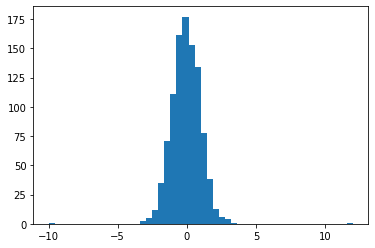

In [7]:
x = np.random.normal(0, 1, 1000)
x = np.r_[x, -3, -10, 12]

plt.hist(x, 50);

In [17]:
def simple_mad(x, thresh = 3.5):
    if len(x.shape) == 1:
        x = x[:,None]
    median = np.median(x)
    diff = np.sqrt((x - median)**2)
    med_abs_deviation = np.median(diff)
    outlier_thresh = median + thresh*1.48*med_abs_deviation
    return outlier_thresh

In [18]:
x[x>simple_mad(x, thresh=3.5)]

array([ 3.5794989, 12.       ])

In [11]:
def mad_based_outlier(points, thresh=3.5):
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

x[mad_based_outlier(x)]

array([  3.5794989, -10.       ,  12.       ])